In [83]:
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import csv
import pandas as pd
import re
import sklearn
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [118]:
# Load data
orig = pd.read_csv('data/final_data.csv').drop(['Unnamed: 0'], axis=1) # Remove unncessary column 
orig = orig[orig['year'] != 2013] # 2013 has incomplete data, so we will remove it

In [119]:
# Group data by the key features we want to focus on
grouped = pd.DataFrame(orig.groupby(['year', 'month', 'state']).count()['day']).rename(columns={"day":"n_incidents"})
grouped.reset_index(inplace=True)
df = orig.merge(grouped, left_on=['year', 'month', 'state'], right_on=['year', 'month', 'state'])

In [120]:
# Create the state_data csv
state_data = df.drop(['incident_id', 'city_or_county', 'address', 'congressional_district', 'incident_characteristics',
             'participant_age', 'participant_gender', 'participant_name', 'participant_relationship', 
             'participant_status', 'participant_type', 'state_house_district', 'state_senate_district', 
             'gun_stolen', 'gun_type', 'n_killed', 'n_injured', 'n_guns_involved',
             'latitude', 'longitude', 'n_people', 'n_young', 'n_mid', 'n_old', 'n_female', 'n_male',
             'n_unknown_gender', 'n_unknown_age', 'day', 'Population'
             ], axis=1).drop_duplicates().sort_values(['state', 'year', 'month'])
print(state_data.shape)
state_data.head(15)

(2520, 19)


,year,month,state,Mental_Health_Records_Submitted_2008,Mental_Health_Records_Submitted_2017,Gun_Sale_Denials_2008,Gun_Sale_Denials_2017,Giffords Gun Safety Score,Gun Deaths per 100k People (2018),Gun Death Rate (Ranked High to Low),Rank,# of guns per capita,# of guns registered,Permit Type,Handgun_Carry_Permit_Fee,Years_Valid,5_Year_Cost,Happiness Score,n_incidents
117812,2014,1,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,70
117882,2014,2,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,47
117929,2014,3,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,66
117995,2014,4,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,71
118066,2014,5,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,66
118132,2014,6,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,59
118191,2014,7,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,76
118267,2014,8,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,69
118336,2014,9,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,44
118380,2014,10,Alabama,155,5036,32,125,F,22.9,2.0,7,0.033,161641,Concealed handgun permit,25.0,5,25,4,54


In [121]:
# Drop extraneous columns
df = df.drop(['incident_id', 'city_or_county', 'address', 'congressional_district', 'incident_characteristics',
             'participant_age', 'participant_gender', 'participant_name', 'participant_relationship', 
             'participant_status', 'participant_type', 'state_house_district', 'state_senate_district', 
             'gun_stolen', 'gun_type',
             'Permit Type'
             ], axis=1)

df.head()

,year,month,day,state,n_killed,n_injured,latitude,longitude,n_guns_involved,n_people,...,Gun Death Rate (Ranked High to Low),Rank,# of guns per capita,# of guns registered,Population,Handgun_Carry_Permit_Fee,Years_Valid,5_Year_Cost,Happiness Score,n_incidents
0,2014,1,1,Pennsylvania,0,1,39.9641,-75.1916,NaN,2.0,...,26.0,22,0.018,236377,12802503,20.0,5,20,2,142
1,2014,1,1,Pennsylvania,0,1,40.0331,-75.1069,NaN,1.0,...,26.0,22,0.018,236377,12802503,20.0,5,20,2,142
2,2014,1,1,Pennsylvania,0,1,40.2138,-74.8426,NaN,1.0,...,26.0,22,0.018,236377,12802503,20.0,5,20,2,142
3,2014,1,2,Pennsylvania,0,1,39.9421,-75.1539,NaN,3.0,...,26.0,22,0.018,236377,12802503,20.0,5,20,2,142
4,2014,1,2,Pennsylvania,0,1,39.9641,-75.1916,NaN,2.0,...,26.0,22,0.018,236377,12802503,20.0,5,20,2,142


In [122]:
# One-hot encoding states
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(pd.DataFrame(orig['state']))
encoded = pd.DataFrame(enc.transform(orig[['state']]).toarray())

# Assigning states to column names
state_list = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

encoded.columns = state_list

# Merge with original dataframe
df = df.merge(encoded, left_index=True, right_index=True)
df = df.drop(['state'], axis=1)

In [123]:
# Fill in all missing data: assume that there must be at least one gun involved and that any missing
# ages or locations can be 0 (this has affects on final results)
df['n_guns_involved'] = df['n_guns_involved'].fillna(1)
df = df.fillna(0)

In [124]:
# Move n_incidents to the front for easier manipulation
n_incidents = df['n_incidents']
df.drop(labels=['n_incidents'], axis=1,inplace = True)
df.insert(0, 'n_incidents', n_incidents)

In [125]:
from pathlib import Path
import os

# Load raw data
directory = os.path.dirname(str(Path().resolve()) + '\\')

In [126]:
# Group by year and state, send to Tyler
df2 = pd.DataFrame(orig.groupby(['year', 'state']).count()['day']).rename(columns={"day":"n_incidents"})
df2.to_csv(os.path.join(directory, 'data', 'No. Incidents by Year and State.csv'))
grouped.to_csv(os.path.join(directory, 'data', 'grouped by year state and month.csv'))
state_data.to_csv(os.path.join(directory, 'data', 'state_data.csv'))

In [132]:
# Run ML on state-level incidents (drop incident level data, groupby again)
state_data = pd.read_csv('data/state_data.csv').drop(['Unnamed: 0', 'Handgun_Carry_Permit_Fee', 'Permit Type', 'Years_Valid'], axis=1)
state_data = state_data.rename(index=str, columns={'Mental_Health_Records_Submitted_2008': 'Mental Health 2008', 
                                      'Mental_Health_Records_Submitted_2017': 'Mental Health 2017',
                                      'Gun_Sale_Denials_2008': 'Gun Denials 2008',
                                      'Gun_Sale_Denials_2017': 'Gun Denials 2017',
                                      'Rank': 'Gun Ownership Rank',
                                      '5_Year_Cost': '5 Year Permit Cost'
                                     })

In [133]:
# One-hot encode the new state year month dataframe
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(pd.DataFrame(state_data['state']))
state_encoded = pd.DataFrame(enc.transform(state_data[['state']]).toarray())

# Assigning states to column names
state_list = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

state_encoded.columns = state_list
state_encoded = state_encoded.reset_index()
state_data = state_data.reset_index()

# Merge with original state dataframe
state_data = state_data.merge(state_encoded, left_index=True, right_index=True)
state_data = state_data.drop(['state', 'index_x'], axis=1)

In [134]:
giff_list = ['A', 'A-', 'B', 'B+', 'B-', 'C', 'C+', 'C-', 'D', 'D+', 'D-', 'F']

# One-hot encode Giffords gun safety grade
enc_giff = OneHotEncoder(handle_unknown='ignore')

# Include all letter grades, regardless of what the data set has
temp = state_data['Giffords Gun Safety Score'].copy()
temp = temp.append(pd.Series(giff_list), ignore_index=True)
enc_giff.fit(pd.DataFrame(temp))

# Encode the actual values
giff_encoded = pd.DataFrame(enc_giff.transform(state_data[['Giffords Gun Safety Score']]).toarray())
giff_list = enc_giff.categories_[0]  # get the encoded column names

# Assigning grades to column names
giff_encoded.columns = giff_list
# Merge with original state dataframe
state_data = state_data.merge(giff_encoded, left_index=True, right_index=True)
state_data = state_data.drop(['Giffords Gun Safety Score', 'index_y'], axis=1)

In [135]:
# Run on state-level data - Linear Regression
X = state_data.iloc[:, state_data.columns != 'n_incidents']
y = state_data['n_incidents']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear model
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)
A = reg.coef_
b = reg.intercept_

lin_train, lin_test = reg.score(X_train, y_train), reg.score(X_test, y_test)

In [136]:
# Lasso regularized linear model
reg_lass = linear_model.Lasso(alpha=0.1)
reg_lass.fit(X_train, y_train)
reg_lass.score(X_train, y_train)
A_lass = reg_lass.coef_
b_lass = reg_lass.intercept_

lin_lasso_train, lin_lasso_test = reg_lass.score(X_train, y_train), reg_lass.score(X_test, y_test)

In [137]:
# Lasso regularized linear model with several alphas
alphas_lass = np.linspace(0.000000001, 1.0, 100)
scores_lass_train = []
scores_lass_test = []

for i in alphas_lass:
    reg_lass = linear_model.Lasso(alpha=i)
    reg_lass.fit(X_train, y_train)
    
    scores_lass_train.append(reg_lass.score(X_train, y_train))
    scores_lass_test.append(reg_lass.score(X_test, y_test))

In [138]:
# Ridge regularized linear model with several alphas
from sklearn.linear_model import Ridge

alphas_ridge = np.linspace(0.00001, 1.0, 20)
scores_ridge_train = []
scores_ridge_test = []

for i in alphas_ridge:
    reg_ridge = Ridge(alpha=i)
    reg_ridge.fit(X_train, y_train)
    
    scores_ridge_train.append(reg_ridge.score(X_train, y_train))
    scores_ridge_test.append(reg_ridge.score(X_test, y_test))

In [139]:
# CART model
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

reg_cart = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
reg_cart.fit(X_train, y_train)
reg_train, reg_test = reg_cart.score(X_train, y_train), reg_cart.score(X_test, y_test)

In [140]:
# Polynomial regression for 2 degrees
from sklearn.preprocessing import PolynomialFeatures

poly_reg2 = PolynomialFeatures(degree=2)
X_poly2 = poly_reg2.fit_transform(X_train)
X_test_poly2 = poly_reg2.fit_transform(X_test)

pol_reg2 = LinearRegression()
pol_reg2.fit(X_poly2, y_train)
pol2_train, pol2_test = pol_reg2.score(X_poly2, y_train), pol_reg2.score(X_test_poly2, y_test)

In [141]:
# Polynomial regression with 3 degrees
poly_reg3 = PolynomialFeatures(degree=3)
X_poly3 = poly_reg3.fit_transform(X_train)
X_test_poly3 = poly_reg3.fit_transform(X_test)

pol_reg3 = LinearRegression()
pol_reg3.fit(X_poly3, y_train)
pol3_train, pol3_test = pol_reg3.score(X_poly3, y_train), pol_reg3.score(X_test_poly3, y_test)

In [142]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

depths = np.linspace(2, 25, 20)
scores_rf_train = []
scores_rf_test = []

for i in depths:
    regr = RandomForestRegressor(max_depth=i, random_state=0, n_estimators=100)
    regr.fit(X_train, y_train)
    
    scores_rf_train.append(regr.score(X_train, y_train))
    scores_rf_test.append(regr.score(X_test, y_test))

In [143]:
# Make predictions

# Make dataframe for predictions
predictors = state_data.drop(['n_incidents'], axis=1)
predictors['year'] = predictors['year'] + 5

In [144]:
# Find states that are missing data (no gun incidents for that month)
state_counts = grouped[grouped['year'] != 2018].groupby(['year', 'state']).size().reset_index().rename(columns={0:'count'})
missing = state_counts[state_counts['count'] != 12]

In [145]:
# Add Missing columns
"""
These are the state/year combos that are missing:

Hawaii (2014, 2015, 2017), New Hampshire (2014), 
Wyoming (2014, 2015, 2016, 2017), Maine (2015), 
North Dakota (2015, 2016), South Dakota (2016, 2017),
Vermont (2016, 2017)

"""

"""
Missing months:

Hawaii 2014 2, 5, 10; Hawaii 2015 1; Hawaii 2017 8;
New Hampshire 2014 4;
Wyoming 2014 3, 4, 5; Wyoming 2015 8, 10; Wyoming 2016 5, 12; Wyoming 2017 1, 3, 7, 10;
Maine 2015 9;
North Dakota 2015 4; North Dakota 2016 7, 9;
South Dakota 2016 1; South Dakota 2017 2;
Vermont 2016 4, 7, 8, 10; Vermont 2017 6, 12

"""

# Making dataframes for each
Hawaii_df = predictors[(predictors['Hawaii'] == 1)].iloc[0:1]
NH_df = predictors[(predictors['New Hampshire'] == 1)].iloc[0:1]
Wyoming_df = predictors[(predictors['Wyoming'] == 1)].iloc[0:1]
Maine_df = predictors[(predictors['Maine'] == 1)].iloc[0:1]
ND_df = predictors[(predictors['North Dakota'] == 1)].iloc[0:1]
SD_df = predictors[(predictors['South Dakota'] == 1)].iloc[0:1]
Vermont_df = predictors[(predictors['Vermont'] == 1)].iloc[0:1]

# Inputting "correct" year, month for each state
Hawaii_df = Hawaii_df.append([Hawaii_df]*4, ignore_index=True)
Hawaii_df['year'] = [2019, 2019, 2019, 2020, 2022]
Hawaii_df['month'] = [2, 5, 10, 1, 8]

NH_df['year'] = [2019]
NH_df['month'] = [4]

Wyoming_df = Wyoming_df.append([Wyoming_df]*10, ignore_index=True)
Wyoming_df['year'] = [2019, 2019, 2019, 2020, 2020, 2021, 2021, 2022, 2022, 2022, 2022]
Wyoming_df['month'] = [3, 4, 5, 8, 10, 5, 12, 1, 3, 7, 10]

Maine_df['year'] = [2020]
Maine_df['month'] = [9]

ND_df = ND_df.append([ND_df]*2, ignore_index=True)
ND_df['year'] = [2020, 2021, 2021]
ND_df['month'] = [4, 7, 9]

SD_df = SD_df.append([SD_df], ignore_index=True)
SD_df['year'] = [2021, 2022]
SD_df['month'] = [1, 2]

Vermont_df = Vermont_df.append([Vermont_df]*5, ignore_index=True)
Vermont_df['year'] = [2021, 2021, 2021, 2021, 2022, 2022]
Vermont_df['month'] = [4, 7, 8, 10, 6, 12]

# Merge all databases together
missing_months = Hawaii_df.append([NH_df, Wyoming_df, Maine_df, ND_df, SD_df, Vermont_df])
predictors = predictors.append(missing_months, ignore_index=True)

In [146]:
# Calculate the predictions
predictions = regr.predict(predictors)
predictors['predictions'] = predictions

In [147]:
# Save as csv for Visualization
predictors.to_csv('data/predictions.csv')

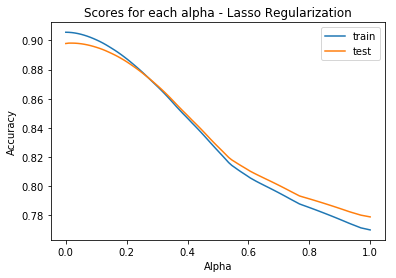

In [148]:
import matplotlib.pyplot as plt
# Table of all results
results = pd.DataFrame(columns=['Train', 'Test'], 
                           index=['Linear Regression','Lasso LR',
                                  'Ridge LR',
                                 'CART', 'Polynomial (d=2)', 'Polynomial (d=3)', 
                                  'Random Forest'])
results.loc['Linear Regression'] = pd.Series({'Train':lin_train, 'Test':lin_test})
results.loc['Lasso LR'] = pd.Series({'Train':np.max(scores_lass_train), 'Test':np.max(scores_lass_test)})
results.loc['Ridge LR'] = pd.Series({'Train':np.max(scores_ridge_train), 'Test':np.max(scores_ridge_test)})
results.loc['CART'] = pd.Series({'Train':reg_train, 'Test':reg_test})
results.loc['Polynomial (d=2)'] = pd.Series({'Train':pol2_train, 'Test':pol2_test})
results.loc['Polynomial (d=3)'] = pd.Series({'Train':pol3_train, 'Test':pol3_test})
results.loc['Random Forest'] = pd.Series({'Train':np.max(scores_rf_train), 'Test':np.max(scores_rf_test)})
results

# Plot of lasso scores
plt.plot(alphas_lass, scores_lass_train, label="train")
plt.plot(alphas_lass, scores_lass_test, label="test")
plt.title('Scores for each alpha - Lasso Regularization')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend();

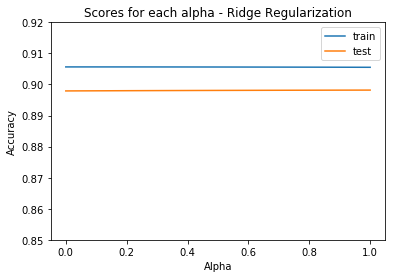

In [149]:
# Plot of ridge scores
plt.plot(alphas_ridge, scores_ridge_train, label="train")
plt.plot(alphas_ridge, scores_ridge_test, label="test")
plt.ylim(0.85, 0.92)
plt.title('Scores for each alpha - Ridge Regularization')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend();

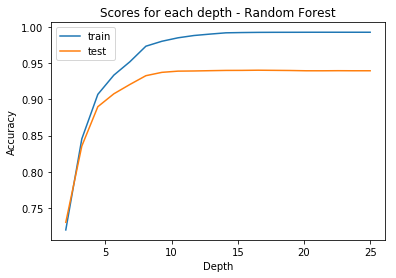

In [150]:
# Plot of Random Forest scores
plt.plot(depths, scores_rf_train, label="train")
plt.plot(depths, scores_rf_test, label="test")
plt.title('Scores for each depth - Random Forest')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend();

In [151]:
# Make a pickle
import pickle

# Dump it to a file that can be read elsewhere
pickle.dump(regr, open( 'data/rf.pkl', 'wb' ))

## Look at ML Setup to Port to Site

In [152]:
print(X_train.shape)
X_train.head()

(2016, 75)


,year,month,Mental Health 2008,Mental Health 2017,Gun Denials 2008,Gun Denials 2017,Gun Deaths per 100k People (2018),Gun Death Rate (Ranked High to Low),Gun Ownership Rank,# of guns per capita,...,B,B+,B-,C,C+,C-,D,D+,D-,F
51,2014,1,0,267,11,19,24.5,1.0,18,0.021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1943,2015,5,0,444,0,7,3.8,47.0,6,0.035,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
495,2017,1,3257,11063,42,202,15.4,19.0,21,0.019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1672,2018,1,1256,399320,45,1050,13.6,23.0,32,0.015,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1359,2017,4,2,30642,1,49,8.3,42.0,39,0.012,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [153]:
print(predictors.shape)
predictors.head()

(2549, 76)


,year,month,Mental Health 2008,Mental Health 2017,Gun Denials 2008,Gun Denials 2017,Gun Deaths per 100k People (2018),Gun Death Rate (Ranked High to Low),Gun Ownership Rank,# of guns per capita,...,B+,B-,C,C+,C-,D,D+,D-,F,predictions
0,2019,1,155,5036,32,125,22.9,2.0,7,0.033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,82.75
1,2019,2,155,5036,32,125,22.9,2.0,7,0.033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,73.31
2,2019,3,155,5036,32,125,22.9,2.0,7,0.033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,78.81
3,2019,4,155,5036,32,125,22.9,2.0,7,0.033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,87.99
4,2019,5,155,5036,32,125,22.9,2.0,7,0.033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,87.77


In [154]:
print(X_train.columns)

Index(['year', 'month', 'Mental Health 2008', 'Mental Health 2017',
       'Gun Denials 2008', 'Gun Denials 2017',
       'Gun Deaths per 100k People (2018)',
       'Gun Death Rate (Ranked High to Low)', 'Gun Ownership Rank',
       '# of guns per capita', '# of guns registered', '5 Year Permit Cost',
       'Happiness Score', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsi

In [155]:
print(predictors.iloc[0])

year                                     2019.000
month                                       1.000
Mental Health 2008                        155.000
Mental Health 2017                       5036.000
Gun Denials 2008                           32.000
Gun Denials 2017                          125.000
Gun Deaths per 100k People (2018)          22.900
Gun Death Rate (Ranked High to Low)         2.000
Gun Ownership Rank                          7.000
# of guns per capita                        0.033
# of guns registered                   161641.000
5 Year Permit Cost                         25.000
Happiness Score                             4.000
Alabama                                     1.000
Alaska                                      0.000
Arizona                                     0.000
Arkansas                                    0.000
California                                  0.000
Colorado                                    0.000
Connecticut                                 0.000


In [156]:
X_train['Happiness Score'].unique()

array([ 2,  3,  6,  5,  9,  4, 29, 11, 16], dtype=int64)